In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip akshit_sum.zip

In [ ]:
data1 = np.load('akshit_sum/data0.npy')
data2 = np.load('akshit_sum/data1.npy')
data3 = np.load('akshit_sum/data2.npy')
lab1 = np.load('akshit_sum/lab0.npy')
lab2 = np.load('akshit_sum/lab1.npy')
lab3 = np.load('akshit_sum/lab2.npy')

In [5]:
X = np.concatenate((data1,data2,data3))
Y = np.concatenate((lab1,lab2,lab3))

X = np.expand_dims(X, 1)      # if numpy array

train_x = X[:int(0.8*len(X))]
val_x = X[int(0.8*len(X)):]

train_y = Y[:int(0.8*len(Y))]
val_y = Y[int(0.8*len(Y)):]

train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

train_y = torch.LongTensor(train_y)
val_y = torch.LongTensor(val_y)

In [6]:
X.shape

(30000, 1, 40, 168)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
class SumNet(torch.nn.Module):
    def __init__(self):
        super(SumNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,8,5,2)
        self.conv2 = torch.nn.Conv2d(8,16,3,1)
        self.conv3 = torch.nn.Conv2d(16,32,3,1)
        self.fc1 = torch.nn.Linear(1824, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 37)
        self.conv_bn_1 = torch.nn.BatchNorm2d(1)
        self.conv_bn_2 = torch.nn.BatchNorm2d(8)
        self.conv_bn_3 = torch.nn.BatchNorm2d(32)

    def forward(self,x):
        x = self.conv_bn_1(x)
        x=self.conv1(x)
        x=torch.nn.functional.relu(x)
        x = self.conv_bn_2(x)
        x=self.conv2(x)
        x=torch.nn.functional.relu(x)
        x=self.conv3(x)
        x=torch.nn.functional.relu(x)
        x = self.conv_bn_3(x)
        x=torch.nn.functional.max_pool2d(x,4)
        x = torch.flatten(x, 1)
        # print("Size",x.shape)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)

        # output = F.log_softmax(x, dim=1)
        return x

In [10]:
model = SumNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=64)
if torch.cuda.is_available():
    model = model.cuda()
    loss = loss.cuda()
    train_y = train_y.cuda()
    train_x = train_x.cuda()
    val_y = val_y.cuda()
    val_x = val_x.cuda()
print(model)

SumNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1824, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (conv_bn_1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [10]:
index_list = np.arange(24000)
train_losses= []
val_losses = []
batch_size = 64*3
for epochs in range(20):
  random.shuffle(index_list)
  for batch_no in range(int(len(train_x)/batch_size)):
    # print(index_list[batch_size*batch_no:batch_size*(batch_no+1)])
    train_batch_x = train_x[index_list[batch_size*batch_no:batch_size*(batch_no+1)]] 
    train_batch_y = train_y[index_list[batch_size*batch_no:batch_size*(batch_no+1)]]

    output_train = model(train_batch_x.float())
    loss_train = loss(output_train, train_batch_y)
    train_losses.append(loss_train.item())
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    output_val = model(val_x.float())
    loss_val = loss(output_val, val_y)
    val_losses.append(loss_val.item())
    scheduler.step(loss_val.item())

  for param_group in optimizer.param_groups:
        lr = param_group['lr']

  if(lr<0.0000001):
    break

  print("Epoch #",epochs,"Completed")
  print(train_losses[-1],val_losses[-1])

Epoch # 0 Completed
3.077280044555664 3.1631946563720703
Epoch # 1 Completed
2.7946717739105225 2.7824740409851074
Epoch # 2 Completed
2.501969575881958 2.670229434967041
Epoch # 3 Completed
2.4847161769866943 2.6070876121520996
Epoch # 4 Completed
2.4635770320892334 2.589892625808716
Epoch   734: reducing learning rate of group 0 to 1.0000e-04.
Epoch # 5 Completed
2.342320680618286 2.5445973873138428
Epoch   852: reducing learning rate of group 0 to 1.0000e-05.
Epoch # 6 Completed
2.193413019180298 2.535539388656616
Epoch   917: reducing learning rate of group 0 to 1.0000e-06.
Epoch   982: reducing learning rate of group 0 to 1.0000e-07.
Epoch # 7 Completed
2.252274751663208 2.535125970840454
Epoch  1047: reducing learning rate of group 0 to 1.0000e-08.


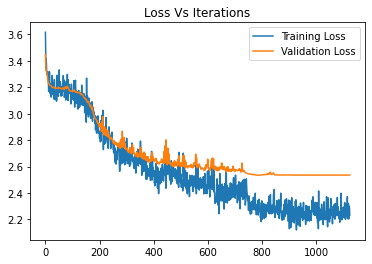

In [19]:
plt.plot(train_losses,label="Training Loss")
plt.plot(val_losses,label="Validation Loss")
plt.title("Loss Vs Iterations")
plt.legend()

In [20]:
def get_accuracy(pred,y):
    accu_sum=0
    for i in range(len(y)):
        maxi=-100000
        maxind=-1
        for j in range(37):
            if pred[i][j] >= maxi:
                maxind = j
                maxi=pred[i][j]
        if(maxind==y[i]):
            accu_sum+=1
        
    return accu_sum/len(y)

In [26]:
torch.save(model,"SumNet_inital_model")

In [29]:
from google.colab import files
files.download('SumNet_inital_model') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
get_accuracy(model(val_x.float()).detach().numpy(),val_y.detach().numpy())

RuntimeError: ignored

In [11]:
saved_model = torch.load("SumNet_inital_model")

In [32]:
saved_model

SumNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1824, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (conv_bn_1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)